In [212]:
# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

# Linear algrebra
import numpy as np
import pywt
# ML and Metrics module
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Data APIs
import yfinance as yf
from pytrends.request import TrendReq

# Technical indicators
from ta.momentum import rsi, stochrsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import ease_of_movement

# Remove warnings
import warnings

warnings.filterwarnings('ignore')


from scipy.signal import savgol_filter, convolve, lfilter

Loading BokehJS ...

# Utils

In [262]:

def polynomialRegression(dataframe, column, order):
    indexs_2 = np.array([i for i in range(len(dataframe[column].values))])
    indexs_2 = np.reshape(indexs_2, newshape=(1,-1))[0]

    RMSEs = []
    for i in range(order):
        features = PolynomialFeatures(degree=i+1)
        x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
        
        model = LinearRegression().fit(x_train_transformed, dataframe[column].values)

        train_pred = model.predict(x_train_transformed)
        rmse_poly_4_train = mean_squared_error(dataframe[column].values, train_pred, squared = False)
        RMSEs.append(rmse_poly_4_train)

    features = PolynomialFeatures(degree=RMSEs.index(min(RMSEs))+1)
    x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
    model = LinearRegression().fit(x_train_transformed, dataframe[column].values)

    x_test_transformed = features.fit_transform(indexs_2.reshape(-1, 1))

    train_pred = model.predict(x_train_transformed)

    test_pred = model.predict(x_test_transformed)
    
    dataframe[f'Poly_{column}'] = test_pred
    return test_pred        



def fourrierFeatureGeneration(df, column, order=30) -> list:
    """Generate a fourrier transformed column in a dataframe with a specified order and column.

    Args:
        df (pd.DataFrame): The dataframe which you want to add a fourrier column
        column (str): The column of the dataframe which you want to compute fft
        order (int, optional): The order of the fourrier transformation. Defaults to 30.

    Returns:
        list: _description_
    """
    close_fft = np.fft.rfft(np.asarray(df[column].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())

    fft_list_m10= np.copy(fft_list)
    fft_list_m10[order:-order] = 0
    if len(df) % 2 ==0:
        #df['fft'] = np.fft.irfft(fft_list_m10)
        return np.fft.irfft(fft_list_m10)#, fft_df
    else:
        #df['fft'] = np.insert(np.fft.irfft(fft_list_m10),0,np.fft.irfft(fft_list_m10)[0],axis=0)
        return np.insert(np.fft.irfft(fft_list_m10),0,np.fft.irfft(fft_list_m10)[0],axis=0)#, fft_df
        
def generateMovingLinearRegression(df,column,window=20)->None:
    """Generate the moving linear regression on a dataframe. This function is inplace=True (returns nothing)

    Args:
        df (pd.DataFrame): The dataframe which you want to add the moving linear regression
        column (str): The column which you want to compute Linear regression on.
        window (int, optional): The window's size on which you want to perform linear regression. Defaults to 20.
    """
    coefs = []
    intercepts = []

    for i in range(len(df)-window):
        ys = df[column].values[i:i+window]
        xs = df.timestamp.values[i:i+window].reshape(-1, 1)
        
        model = LinearRegression().fit(xs,ys)
        
        coefs.append(model.coef_[0])
        intercepts.append(model.intercept_)
        
    ratio = sum([intercepts[i]/[-coef for coef in coefs][i] for i in range(len(coefs))]) / len([intercepts[i]/[-coef for coef in coefs][i] for i in range(len(coefs))])
    df['MLR'] = np.nan
    df['MLR'].iloc[window:] = [intercepts[i]/ratio+coefs[i] for i in range(len(coefs))]

def addIndicators(df:pd.DataFrame,b_engulfings:bool=False, derivative:bool=False, double_derivative:bool=False) -> pd.DataFrame:
    """Apply indicators to the DataFrame.

    Args:
        df (pd.DataFrame): The dataframe you want to add indicators on.
        b_engulfings (bool, optional): Add bearish and bullish engulfing indicators. Defaults to False.
        derivative (bool, optional): Add the first derivative of the Close price. Defaults to False.
        double_derivative (bool, optional): Add the second derivative of the Close price. Defaults to False.

    Returns:
        pd.DataFrame: The same dataframe with indicators
    """
    def isBearishCandleStick(candle) -> bool:
        """Check whether a candle is a bearish candle or not

        Args:
            candle (pd.Series): The current candle that contains OHLC

        Returns:
            bool: A boolean representing if the candle is bearish candle (True) or not (False)
        """
        return candle['Close']<candle['Open']

    def isBullishCandleStick(candle) -> bool:
        """Check whether a candle is a bullish candle or not

        Args:
            candle (pd.Series): The current candle that contains OHLC

        Returns:
            bool: A boolean representing if the candle is bullish candle (True) or not (False)
        """
        return candle['Close']>candle['Open']

    def isBullishEngulfing(previous_candle,current_candle) -> int:
        """A function that check for bullish engulfing pattern through candle stick

        Args:
            previous_candle (pd.Series): The previous candle that contains OHLC
            current_candle (pd.Series): The current candle that contains OHLC

        Returns:
            int: represent the pattern spotting : 1 bullish engulfing, 0 not.
        """
        return 1 if isBearishCandleStick(previous_candle) and isBullishCandleStick(current_candle) and previous_candle['Open']<current_candle['Close'] and previous_candle['Close']>current_candle['Open'] else 0
        
    def isBearishEngulfing(previous_candle,current_candle) -> int:
        """A function that check for bearish engulfing pattern through candle stick

        Args:
            previous_candle (pd.Series): The previous candle that contains OHLC
            current_candle (pd.Series): The current candle that contains OHLC

        Returns:
            int: represent the pattern spotting : 1 bearish engulfing, 0 not.
        """
        return 1 if isBullishCandleStick(previous_candle) and isBearishCandleStick(current_candle) and previous_candle['Close']<current_candle['Open'] and previous_candle['Open']>current_candle['Close'] else 0    
            
    df['High_Low_diff'] = df.High-df.Low
    df['EMA20'] = ema_indicator(df.Close,20)
    df['EMA50'] = ema_indicator(df.Close,50)
    df['EMA100'] = ema_indicator(df.Close,100)
    df['EMA200'] = ema_indicator(df.Close,200)
    df['MACD'] = macd_diff(df.Close)
    df['Stoch_RSI'] = stochrsi(df.Close, 14, smooth1=3, smooth2=3)
    df['Vortex'] = (vortex_indicator_pos(df.High,df.Low,df.Close,20,fillna=True)-1)-(vortex_indicator_neg(df.High,df.Low,df.Close,20,fillna=True)-1)
    df['Bollinger_low'] = bollinger_hband(df.Close,20,fillna=True)
    df['Bollinger_high'] = bollinger_lband(df.Close,20,fillna=True)
    df['ADX'] = adx(df.High,df.Low,df.Close)
    df['CCI'] = cci(df.High,df.Low,df.Close,14)
    df['OVB'] = (np.sign(df.Close.diff())*df.Volume).fillna(0).cumsum()
    df['OVB_EMA200'] = ema_indicator(df.OVB,200)
    trixLength = 9
    trixSignal = 21
    df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
    df['TRIX_PCT'] = df["TRIX"].pct_change()*100
    df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
    df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
    df['EVM'] = ease_of_movement(df.High,df.Low,df.Volume,14)
    if b_engulfings==True:
        df['Bullish_engulfing'] = np.nan
        df['Bullish_engulfing'].iloc[1:] = [isBullishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
        df['Bearish_engulfing'] = np.nan
        df['Bearish_engulfing'].iloc[1:] = [isBearishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
    if derivative==True:
        df['Slope'] = df.Close.diff()
    if double_derivative==True:
        df['Acceleration'] = df.Close.diff().diff()
    return df.dropna()

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for _, level in levels]) == 0

def detectSupportAndResistance(df)->list:
    """This function detect using window approach all supports and resistance from a dataframe over a time period.

    Args:
        df (pd.DataFrame): The DataFrame that we want to extract supports and resistances, it must containe OHLC at least.

    Returns:
        list: The list of all supports and resistances timestamped
    """
    pivots = []
    max_list = []
    min_list = []
    for i in range(5, len(df)-5):
        high_range = df['High'][i-5:i+4]
        current_max = high_range.max()

        if current_max not in max_list:
            max_list = []
        max_list.append(current_max)
        if len(max_list) == 5 and is_far_from_level(current_max, pivots, df):
            pivots.append((high_range.idxmax(), current_max))
        
        low_range = df['Low'][i-5:i+5]
        current_min = low_range.min()
        if current_min not in min_list:
            min_list = []
        min_list.append(current_min)
        if len(min_list) == 5 and is_far_from_level(current_min, pivots, df):
            pivots.append((low_range.idxmin(), current_min))
    return list({x:y} for x, y in pivots)

def addTimestampToDf(df)->pd.DataFrame:
    """add timestamp to dataframe as column

    Args:
        df (pd.DataFrame): The Dataframe we want to add timestamp as col

    Returns:
        pd.DataFrame: The Dataframe with the new column
    """
    df['timestamp'] = [round(datetime.timestamp(df.index[ind])) for ind in range(len(df.index))]
    df['timestamp'] = df['timestamp'].astype(int)
    return df

def lowpassfilter(signal, thresh = 0.63, wavelet="db5"):#'sym5', 'coif5', 'bior2.4'
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal


def fft_denoiser(x, n_components=0.0005, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

# Load the data

In [214]:
def prepareDataFrames(symbol='ETH',google_trend=True,interval='15m')->pd.DataFrame:
    """Get Datafram BTC and symbol data from yFinance and optionnaly google_trend data.

    Args:
        symbol (str, optional): The Symbol you want to predict from BTC. Defaults to 'ETH'.
        google_trend (bool, optional): Whether or not you want to add Google Trend Data to the Dataframe, is that case you need to put interval to 1h. Defaults to True.
        interval (str, optional): The interval to construct candlesticks : 1h, 15m, 1m... Defaults to '15m'.

    Returns:
        pd.DataFrame: The Dataframe containing all the data and the features.
    """
    n = 60
    current_date = datetime.today()
    past_date = current_date - relativedelta(days=n)

    hist_BTC = yf.Ticker("BTC-USD").history(interval=interval,start=past_date,end=current_date,tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])
    addTimestampToDf(hist_BTC)
    hist_ETH = yf.Ticker(f"{symbol}-USD").history(interval=interval,start=past_date,end=current_date,tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])
    addTimestampToDf(hist_ETH)
    
    if google_trend==True and interval=='1h':
        merged_BTC_ETH = pd.merge(hist_BTC,hist_ETH, left_on='timestamp',right_on='timestamp',how='inner',suffixes=('',f'_{symbol}')).dropna()
        starting_date = datetime.fromtimestamp(merged_BTC_ETH['timestamp'].iloc[0])
        ending_date = datetime.fromtimestamp(merged_BTC_ETH['timestamp'].iloc[-1])

        pytrends = TrendReq(hl='en-US', tz=360) 
        kw_list = ["BTC","Blockchain","Bitcoin"] # list of keywords to get data 

        pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m') 
        data = pytrends.get_historical_interest(kw_list, year_start=starting_date.year, month_start=starting_date.month, day_start=starting_date.day, hour_start=starting_date.hour, year_end=ending_date.year, month_end=ending_date.month, day_end=ending_date.day, hour_end=ending_date.hour, cat=0, sleep=0)
        data = data.reset_index() 
        data.set_index('date',inplace=True)
        data.BTC = data.BTC + data.Bitcoin

        data.drop(columns=['Bitcoin','isPartial'],inplace=True)
        data.dropna(inplace=True)

        polynomialRegression(data,'BTC',20)
        polynomialRegression(data,'Blockchain',20)
        addTimestampToDf(data)
        merged_BTC_ETH_Gtrend = pd.merge(merged_BTC_ETH,data, left_on='timestamp',right_on='timestamp',how='outer').dropna()
        merged_BTC_ETH_Gtrend = addIndicators(merged_BTC_ETH_Gtrend)
        return merged_BTC_ETH_Gtrend
    else:
        return  addIndicators(pd.merge(hist_BTC,hist_ETH, left_on='timestamp',right_on='timestamp',how='inner',suffixes=('',f'_{symbol}')).dropna())
        
def prepareDataFrame(symbol='ETH',intraday=True, interval='15m')->pd.DataFrame:
    """Get symbol data from yFinance.

    Args:
        symbol (str, optional): The Symbol you want. Defaults to 'ETH'.
        interval (str, optional): The interval to construct candlesticks : 1h, 15m, 1m... Defaults to '15m'.

    Returns:
        pd.DataFrame: The Dataframe containing all the data and the features.
    """
    if intraday==True:
        if interval=='1m':
            n=7
        else:
            n = 59
        current_date = datetime.today()
        past_date = current_date - relativedelta(days=n)

        return addIndicators(addTimestampToDf(yf.Ticker(f"{symbol}-USD").history(interval=interval,start=past_date,end=current_date,tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])  ))
    else:
        return addIndicators(addTimestampToDf(yf.Ticker(f"{symbol}-USD").history(period='max',interval='1d',tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])))
    
def prepareStockDataFrame(symbol='AMZN',intraday=True, interval='15m')->pd.DataFrame:
    """Get symbol data from yFinance.

    Args:
        symbol (str, optional): The Symbol you want. Defaults to 'AMZN'.
        interval (str, optional): The interval to construct candlesticks : 1h, 15m, 1m... Defaults to '15m'.

    Returns:
        pd.DataFrame: The Dataframe containing all the data and the features.
    """
    if intraday==True:
        if interval=='1m':
            n=7
        else:
            n = 59
        current_date = datetime.today()
        past_date = current_date - relativedelta(days=n)

        return addIndicators(addTimestampToDf(yf.Ticker(f"{symbol}").history(interval=interval,start=past_date,end=current_date,tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])  ))
    else:
        return addIndicators(addTimestampToDf(yf.Ticker(f"{symbol}").history(period='max',interval='1d',tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])))

In [29]:
df = prepareDataFrame('ETH',intraday=True,interval='15m')
df.head()

,Open,High,Low,Close,Volume,timestamp,RSI,EMA20,EMA50,EMA100,...,%K,Vortex,Bollinger_low,Bollinger_high,Slope,Acceleration,Bullish_engulfing,Bearish_engulfing,ADX,CCI
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-05 17:00:00+00:00,3451.587402,3469.682129,3451.587402,3468.501953,207878144,1649178000,43.964001,3473.171060,3491.248628,3496.758187,...,0.255962,-0.490351,3532.917498,3418.506110,19.704102,24.567383,0.0,0.0,32.397824,44.742556
2022-04-05 17:15:00+00:00,3468.463379,3471.307617,3464.577393,3465.800049,74086400,1649178900,42.713183,3472.469059,3490.250645,3496.145155,...,0.361799,-0.540020,3519.921371,3423.733341,-2.701904,-22.406006,0.0,0.0,30.957794,134.959061
2022-04-05 17:30:00+00:00,3465.602051,3470.062988,3464.177002,3470.062988,89839616,1649179800,45.354818,3472.239909,3489.458972,3495.628676,...,0.526349,-0.606948,3508.589636,3429.000964,4.262939,6.964844,1.0,0.0,29.649451,137.181928
2022-04-05 17:45:00+00:00,3469.047852,3469.047852,3456.954102,3456.956055,17164288,1649180700,39.347125,3470.784304,3488.184348,3494.862882,...,0.617294,-0.528097,3495.889866,3434.883425,-13.106934,-17.369873,0.0,0.0,28.946331,27.754832
2022-04-05 18:00:00+00:00,3456.394043,3456.394043,3452.974365,3453.756836,0,1649181600,38.023208,3469.162640,3486.834249,3494.048901,...,0.682453,-0.544173,3484.182229,3440.686447,-3.199219,9.907715,0.0,0.0,28.559261,-77.347476


# Moving linear regressions (forward, backward)

In [21]:


window = 8
coefs_2 = []


for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs_2.append(model.coef_[0])

df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs_2
df['Close_final'] = fft_denoiser(df.Close.values,50)

df.dropna(inplace=True)


In [22]:
df

,Open,High,Low,Close,Volume,timestamp,RSI,EMA20,EMA50,EMA100,...,Bollinger_low,Bollinger_high,Slope,Acceleration,Bullish_engulfing,Bearish_engulfing,ADX,CCI,B_MLR_coefs,Close_final
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-05 19:00:00+00:00,3449.525146,3449.525146,3432.785400,3432.785400,82847744,1649185200,30.361056,3461.771922,3480.984556,3490.068804,...,3473.114610,3440.010659,-17.276855,-16.002197,0.0,0.0,28.985400,-200.565200,-0.003243,3432.744401
2022-04-05 19:15:00+00:00,3431.378418,3453.974365,3428.375000,3453.974365,232673280,1649186100,43.751068,3461.029298,3479.925332,3489.354062,...,3473.113600,3440.006371,21.188965,38.465820,1.0,0.0,29.340005,-105.410050,-0.004566,3454.446610
2022-04-05 19:30:00+00:00,3455.194092,3459.154785,3453.204102,3453.790283,87834624,1649187000,43.672504,3460.339868,3478.900428,3488.649829,...,3473.027306,3440.606972,-0.184082,-21.373047,0.0,0.0,29.059918,-7.702176,-0.003304,3453.695438
2022-04-05 19:45:00+00:00,3453.693115,3462.602295,3453.693115,3462.602295,76591104,1649187900,48.445082,3460.555337,3478.261286,3488.134036,...,3473.509384,3440.698819,8.812012,8.996094,1.0,0.0,28.408782,43.142974,-0.001238,3462.073895
2022-04-05 20:00:00+00:00,3462.439453,3467.147949,3459.859375,3464.065918,118631424,1649188800,49.214759,3460.889678,3477.704605,3487.657440,...,3473.880779,3440.654548,1.463623,-7.348389,0.0,0.0,27.304108,76.532107,0.000514,3465.180462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 08:15:00+00:00,1930.257935,1934.052979,1930.093750,1933.901001,37701632,1654071300,48.193857,1934.012985,1939.757099,1943.948012,...,1939.665857,1923.704797,3.797485,4.429199,0.0,0.0,21.193039,-9.300422,-0.000892,1933.959278
2022-06-01 08:30:00+00:00,1934.140015,1935.867676,1933.638306,1933.864380,56291328,1654072200,48.143952,1933.998832,1939.526012,1943.748336,...,1939.864095,1923.818754,-0.036621,-3.834106,0.0,0.0,20.284812,41.969865,-0.000766,1933.941023
2022-06-01 08:45:00+00:00,1933.792725,1936.321411,1933.792725,1936.074219,54548480,1654073100,51.413480,1934.196488,1939.390648,1943.596373,...,1940.324433,1923.960797,2.209839,2.246460,1.0,0.0,19.336411,62.332596,-0.000541,1936.372292


# Drawing Lines

AttributeError: 'DataFrame' object has no attribute 'Close_final'

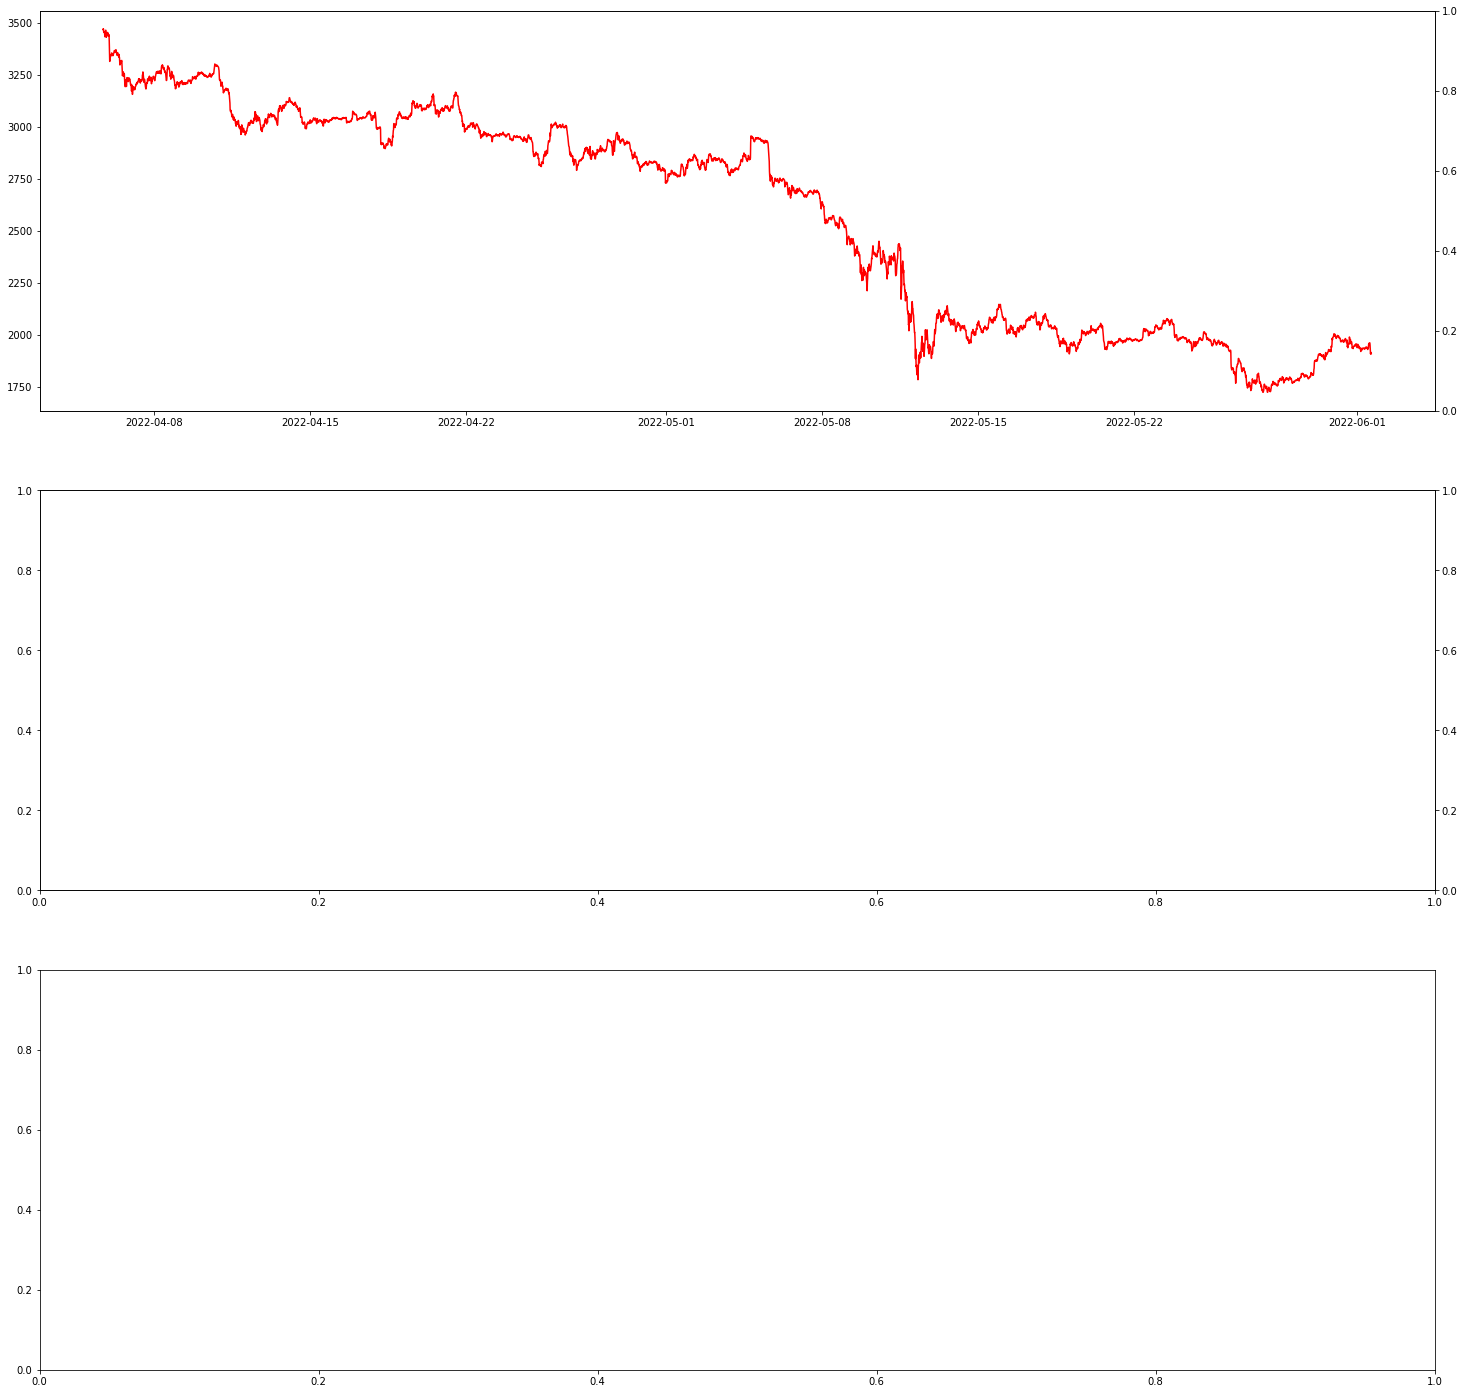

In [30]:
fig, ax_left = plt.subplots(3, figsize=(25,25))
ax_right =[]
ax_right.append(ax_left[0].twinx())
ax_right.append(ax_left[1].twinx())

ax_left[0].plot(df.index, df.Close, color='red',label='Close')
#ax_left[0].plot(df.Close_1[-400:], color='orange',label='savgol_filter')
#ax_left[0].plot(df.Close_2[-400:], color='blue',label='hpfilter')
#ax_left[0].plot(df.Close_3[-400:], color='gray',label='DWT')
ax_left[0].plot(df.index,df.Close_final, color='gray',label='DWT')
ax_left[0].legend(loc="upper left")


ax_left[1].plot(df.Close[-400:], color='red',label='Close')
ax_right[1].plot(df['B_MLR_coefs'][-400:], color='black',label='B_MLR_coefs')
ax_right[1].axhline(y=0, color='black', linestyle='--')
ax_right[1].legend(loc="upper left")
ax_left[1].legend(loc="upper right")
sns.histplot(data=df['B_MLR_coefs'], ax = ax_left[2])

# Creating a strategy

In [81]:
df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs'].diff()
df.dropna(inplace=True)

In [82]:
df['BUY_SELL'] = np.nan
df['BUY_SELL'].iloc[1:] = [0 if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else -1 if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else 1 for i in range(1,len(df))]
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,timestamp,RSI,EMA20,EMA50,EMA100,...,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff,BUY_SELL,B_MLR_coefs_filtered_1,B_MLR_coefs_filtered_3,Close_1,Close_2,Close_3,Close_final
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-05 20:15:00+00:00,3463.566650,3463.566650,3454.183594,3454.183594,26022912,1649189700,44.395380,3460.251003,3476.781296,3486.840030,...,-0.000258,-0.001708,-0.000089,0.0,-0.001708,0.001845,3446.391208,3447.573782,3432.053227,3443.878384
2022-04-05 20:30:00+00:00,3448.948242,3448.948242,3428.223877,3430.027588,0,1649190600,35.296663,3457.372583,3474.947818,3485.715031,...,-0.000551,-0.001712,-0.000293,0.0,-0.001712,0.001633,3446.104035,3445.391107,3426.891494,3442.047648
2022-04-05 20:45:00+00:00,3430.499756,3440.102295,3430.499756,3439.620361,94144512,1649191500,40.510820,3455.681895,3473.562427,3484.802265,...,-0.001233,-0.001557,-0.000683,0.0,-0.001557,0.000014,3446.081015,3442.993050,3434.343541,3442.807131
2022-04-05 21:00:00+00:00,3438.697021,3438.912109,3433.393311,3434.566650,0,1649192400,38.739635,3453.670919,3472.033181,3483.807501,...,-0.001977,-0.001148,-0.000744,0.0,-0.001148,-0.002150,3446.276140,3440.356586,3439.453391,3443.135724
2022-04-05 21:15:00+00:00,3435.475586,3440.354004,3435.475586,3437.220215,718848,1649193300,40.217620,3452.104186,3470.667967,3482.884980,...,-0.001730,-0.000670,0.000247,-1.0,-0.000670,-0.003746,3445.767295,3437.456578,3434.149397,3440.950500


In [83]:
every_min = df.BUY_SELL.replace(1.0,0.0).replace(-1.0,1.0).values
every_max = df.BUY_SELL.replace(-1.0,0.0).values

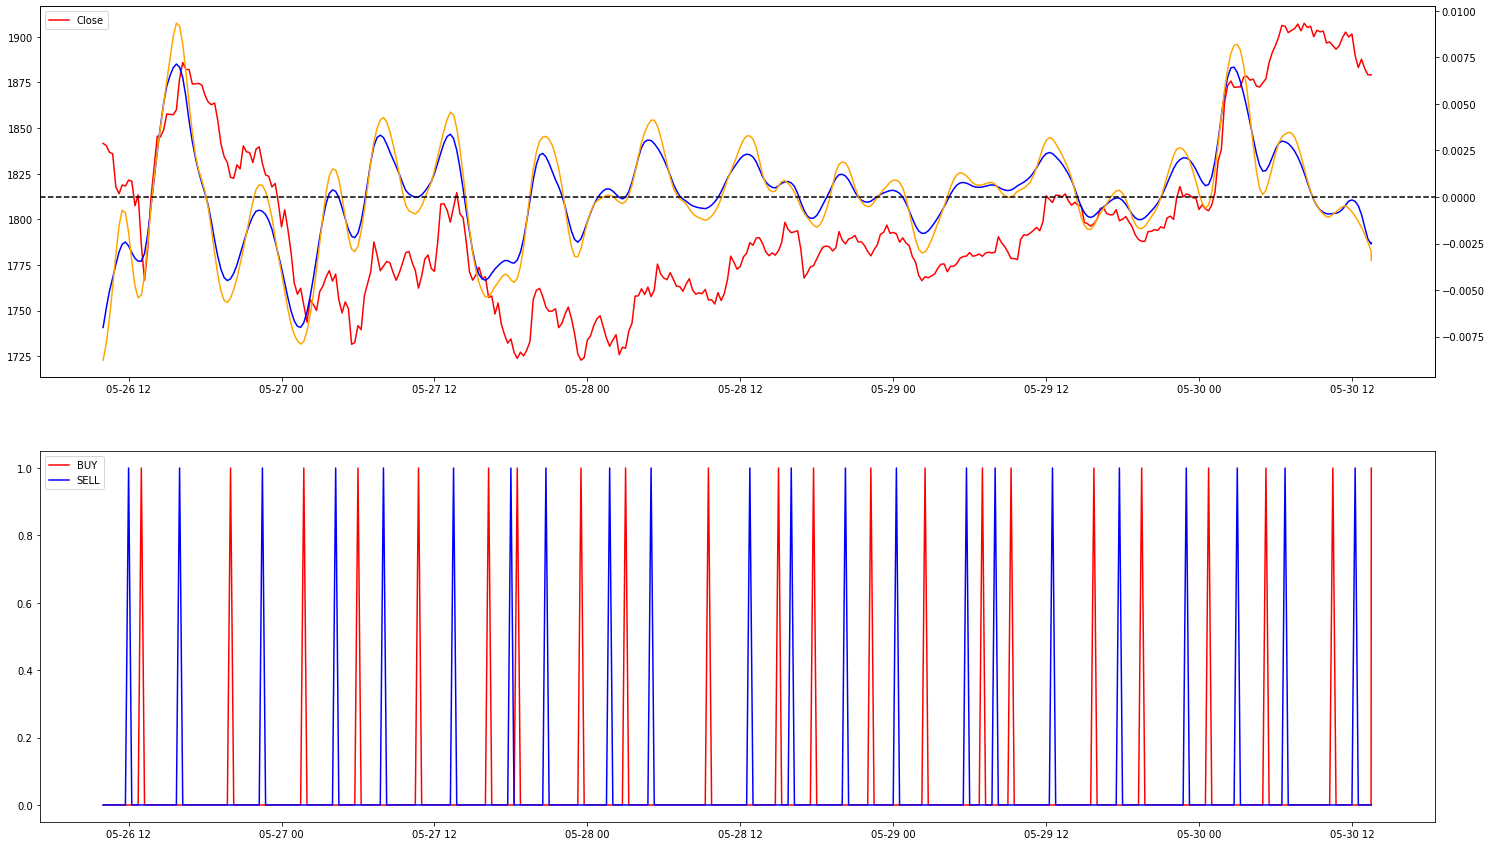

In [84]:
fig, ax_left = plt.subplots(2, figsize=(25,15))

ax_left[0].plot(df.Close[-400:], color='red',label='Close')
ax_right = ax_left[0].twinx()
ax_right.plot(df['B_MLR_coefs'][-400:], color='blue',label='F MLR coefs')
ax_right.plot(df['B_MLR_coefs_filtered'][-400:], color='orange',label='F MLR coefs filtered')
ax_right.axhline(y=0, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
ax_left[1].plot(df.index[-400:],every_min[-400:], color='red',label='BUY')
ax_left[1].plot(df.index[-400:],every_max[-400:], color='blue',label='SELL')
ax_left[1].legend(loc="upper left")

In [85]:
trades = df[df['BUY_SELL']!=0].iloc[1:][['Close','BUY_SELL']]
trades['Change']=trades.Close.pct_change()*100
trades = trades[trades['BUY_SELL']!=-1.0]
print(f'Gain {round(trades.Change.sum())} %')
print(f'Winrate {round(len(trades[trades.Change>0])*100/len(trades))} %')

Gain 231 %
Winrate 84 %


# Using the strategy with KuCoin API

In [215]:
from kucoin.client import Market
import pandas as pd
import numpy as np
from datetime import datetime
import time
import math
client = Market(url='https://api.kucoin.com')
#[pair['symbol'] for pair in client.get_symbol_list() if pair['enableTrading']==True ]

## Find optimal parameters

In [ ]:
import traceback
results = []
for w in range(5,20):
    for c in range(5,70):
        try:
            klines = client.get_kline('ETH-USDT','15min', startAt=round(datetime.now().timestamp())-900000, endAt=round(datetime.now().timestamp()))
            #klines = client.get_kline('BTC-USDT','1day',startAt=1603100941, endAt=round(datetime.now().timestamp()),)
            df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Transaction volume','Transaction amount'],dtype=float)
            df = df.sort_values(by='Date')
            df['Timestamp'] = df['Date'].astype(int)
            df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
            df = df.set_index('Date')
            #print(len(df))
            #df.tail()
            coefs_2 = []
            intercepts_2 = []

            window = w
            for i in range(window,len(df)):
                ys = df['Close'].values[i-window:i]
                xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
                
                model = LinearRegression().fit(xs,ys)
                
                coefs_2.append(model.coef_[0])
                intercepts_2.append(model.intercept_)
                
            ratio = sum([intercepts_2[i]/[-coef for coef in coefs_2][i] for i in range(len(coefs_2))]) / len([intercepts_2[i]/[-coef for coef in coefs_2][i] for i in range(len(coefs_2))])
            df['B_MLR'] = np.nan
            df['B_MLR'].iloc[window:] = [intercepts_2[i]/ratio+coefs_2[i] for i in range(len(coefs_2))]
            df['B_MLR_coefs'] = np.nan
            df['B_MLR_coefs'].iloc[window:] = coefs_2

            df.dropna(inplace=True)
            df['B_MLR_coefs_filtered'] = savgol_filter(df['B_MLR_coefs'].values, c, 2,mode='nearest')

            df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()
            df.dropna(inplace=True)
            df['BUY_SELL'] = np.nan
            df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" for i in range(1,len(df))]
            df.dropna(inplace=True)

            trades = df[df['BUY_SELL']!="HOLD"].iloc[1:][['Close','BUY_SELL']]
            trades['Change']=trades.Close.pct_change()*100
            trades = trades[trades['BUY_SELL']!="BUY"]
            if len(trades)!=0:
                dict_res = {"winrate":round(len(trades[trades.Change>0])*100/len(trades)),
                                "gain":trades.Change.sum(),
                                "window":w,
                                "coefficient":c}
                print(dict_res)
                #print(f'Gain {trades.Change.sum()} %')
                #print(f'Winrate {round(len(trades[trades.Change>0])*100/len(trades))} %')
                results.append(dict_res)
        except Exception as e:
            print(traceback.format_exc())

df_results = pd.DataFrame(data=results)
df_results.head()
df_results.to_csv('./maximize_gain.csv')


In [ ]:
%pip install plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Mesh3d(z=df_results.gain.values, x=df_results.window.values, y=df_results.coefficient.values)])
fig.update_layout(title='Maximize gain', autosize=False,
                  width=1200, height=500,
                  )
fig.show()

In [ ]:
fig = go.Figure(data=[go.Mesh3d(z=df_results.winrate.values, x=df_results.window.values, y=df_results.coefficient.values)])
fig.update_layout(title='Maximize gain', autosize=False,
                  width=1200, height=500,
                  )
fig.show()

## Implementing strategy

In [130]:
import pywt

def lowpassfilter(signal, thresh = 0.63, wavelet="db5"):#'sym5', 'coif5', 'bior2.4'
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    if len(signal) % 2==0:
        return reconstructed_signal
    else:
        return reconstructed_signal[1:]

In [125]:
import requests
response = requests.get(f'https://crypto-api.zlochteam.com/get-BTC-tweets').json()
print(f'{response["total"]} records in the dataset')

df_tweets = pd.DataFrame(response['data'])
df_tweets['Date'] = df_tweets['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tweets = df_tweets.set_index('Date')
df_tweets = df_tweets.sort_index(axis=0)
df_tweets.head()

response = requests.get(f'https://crypto-api.zlochteam.com/get-trading-view-indicators').json()
print(f'{response["total"]} records in the dataset')

df_tvta = pd.DataFrame(response['data'])
df_tvta['Date'] = df_tvta['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tvta = df_tvta.set_index('Date')
df_tvta = df_tvta.sort_index(axis=0)
df_tvta.head()



455 records in the dataset
3192 records in the dataset


,buy,neutral,sell,symbol,timestamp
Date,,,,,
2022-05-28 15:20:20,14,9,3,BTC,1653744020
2022-05-28 15:21:20,14,9,3,BTC,1653744080
2022-05-28 15:22:20,14,9,3,BTC,1653744140
2022-05-28 15:23:21,14,10,2,BTC,1653744201
2022-05-28 15:24:21,15,10,1,BTC,1653744261


Gain : 136 %
Winrate : 63 %
Total trades : 587


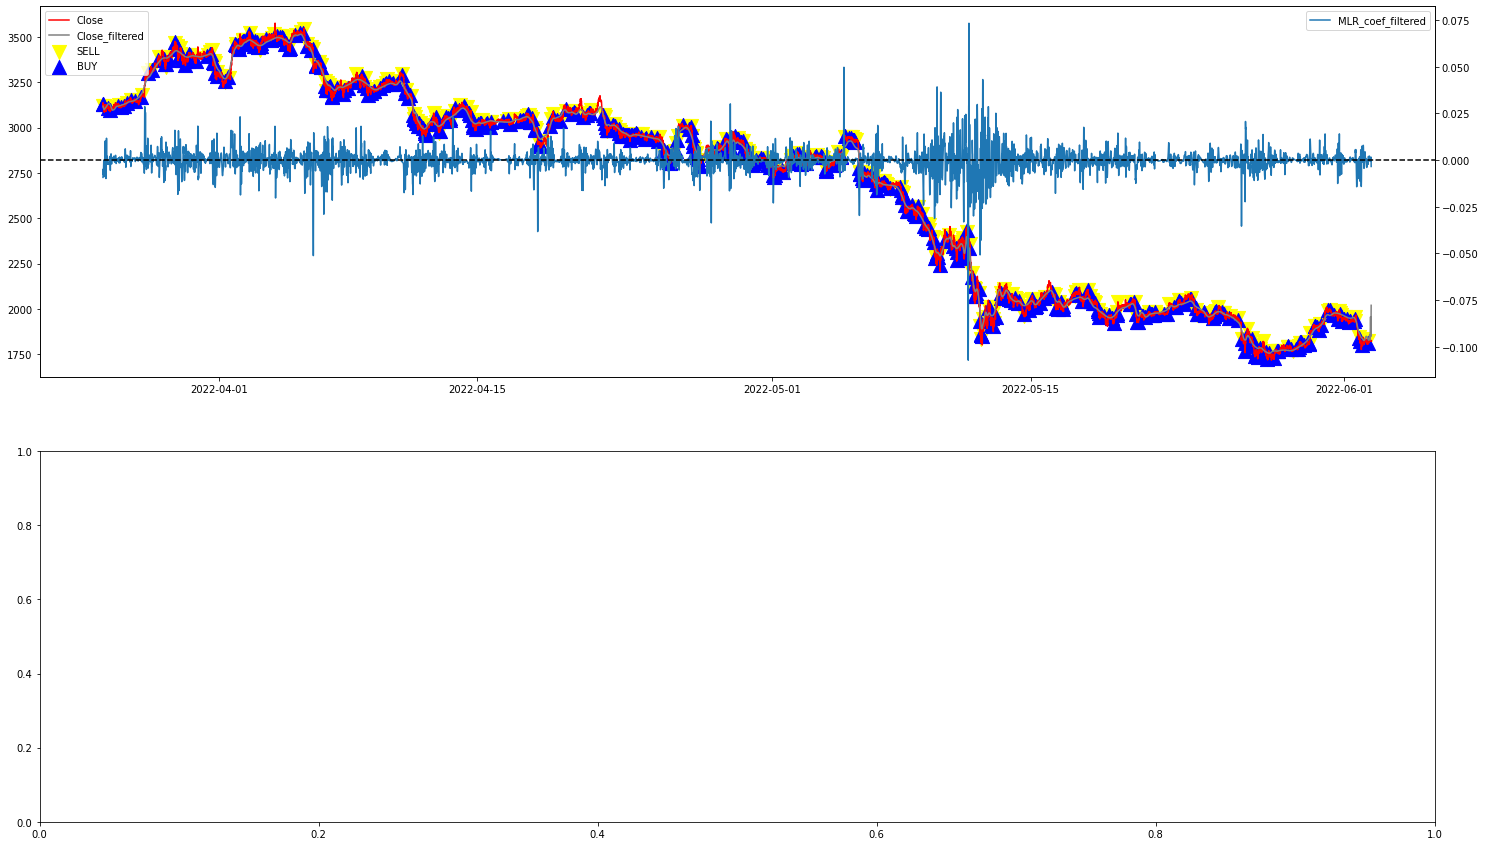

In [174]:
df = pd.read_csv('./data/ETH-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')


df = df[-20000:]
addIndicators(df)
df['Close_filtered'] = lowpassfilter(df['Close'].values, 0.04)


coefs_2 = []
window = 8
for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs_2.append(model.coef_[0])
    
df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs_2

df.dropna(inplace=True)
df['B_MLR_coefs_filtered'] =  lowpassfilter(df['B_MLR_coefs'].values, 0.1)#savgol_filter(df['B_MLR_coefs'].values, 19, 2,mode='wrap',deriv=0)

df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()
df.dropna(inplace=True)
df['BUY_SELL'] = np.nan
##df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 and df['B_MLR_coefs_filtered'][i]<=-0.000025/2 else "SELL" if  df['B_MLR_coefs_filtered_diff'][i-1]>0 and df['B_MLR_coefs_filtered_diff'][i]<0 and df['B_MLR_coefs_filtered'][i]>=0.000020 else "HOLD" for i in range(1,len(df))]
#df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" if  (df['B_MLR_coefs_filtered_diff'][i-1]>0 and df['B_MLR_coefs_filtered_diff'][i]<0) else "HOLD" for i in range(1,len(df))]
#df.dropna(inplace=True)

trades = []
df['BUY'] = np.nan
df['SELL'] = np.nan
OPENED = False
for i in range(1,len(df)):
    if OPENED == False:
        if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 and df['B_MLR_coefs_filtered'][i]<0  and df['Stoch_RSI'][i]>0.2 :
            df['BUY'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'BUY'
            trades.append(df.iloc[i].values)
            OPENED = True
            LAST_BUY_PRICE = df.Close.iloc[i]
    else:
        if df['B_MLR_coefs_filtered_diff'][i-1]>0 and df['B_MLR_coefs_filtered_diff'][i]<0 :
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False
        elif df['Close'][i]<=0.95*LAST_BUY_PRICE:
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False
            
        
trades = pd.DataFrame(trades, columns=df.columns)
trades['Change']=trades.Close.pct_change()*100
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum())} %")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)}")

#start = df_tvta.timestamp.iloc[0]
#df = df[df['Timestamp']>=start]
#df_tweets= df_tweets[df_tweets['timestamp']>=start]


fig, ax_left = plt.subplots(2, figsize=(25,15))

ax_left[0].plot(df.Close, color='red',label='Close')
ax_left[0].plot(df.Close_filtered, color='gray',label='Close_filtered')
ax_left[0].scatter(df.index, df['SELL'], color='yellow',label='SELL',marker='v',s=200)
ax_left[0].scatter(df.index, df['BUY'], color='blue',label='BUY',marker='^',s=200)
ax_right = ax_left[0].twinx()
ax_right.plot(df.B_MLR_coefs_filtered,label='MLR_coef_filtered')
ax_right.axhline(y=0, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
ax_right.legend(loc="upper right")

#ax_left[1].plot(df.Stoch_RSI, color='red',label='Stoch_RSI')
#ax_left[1].axhline(y=0.2, color='black', linestyle='--')
#ax_left[1].axhline(y=0.8, color='black', linestyle='--')

1500
Gain : -6 %
Winrate : 0 %
Total trades : 4


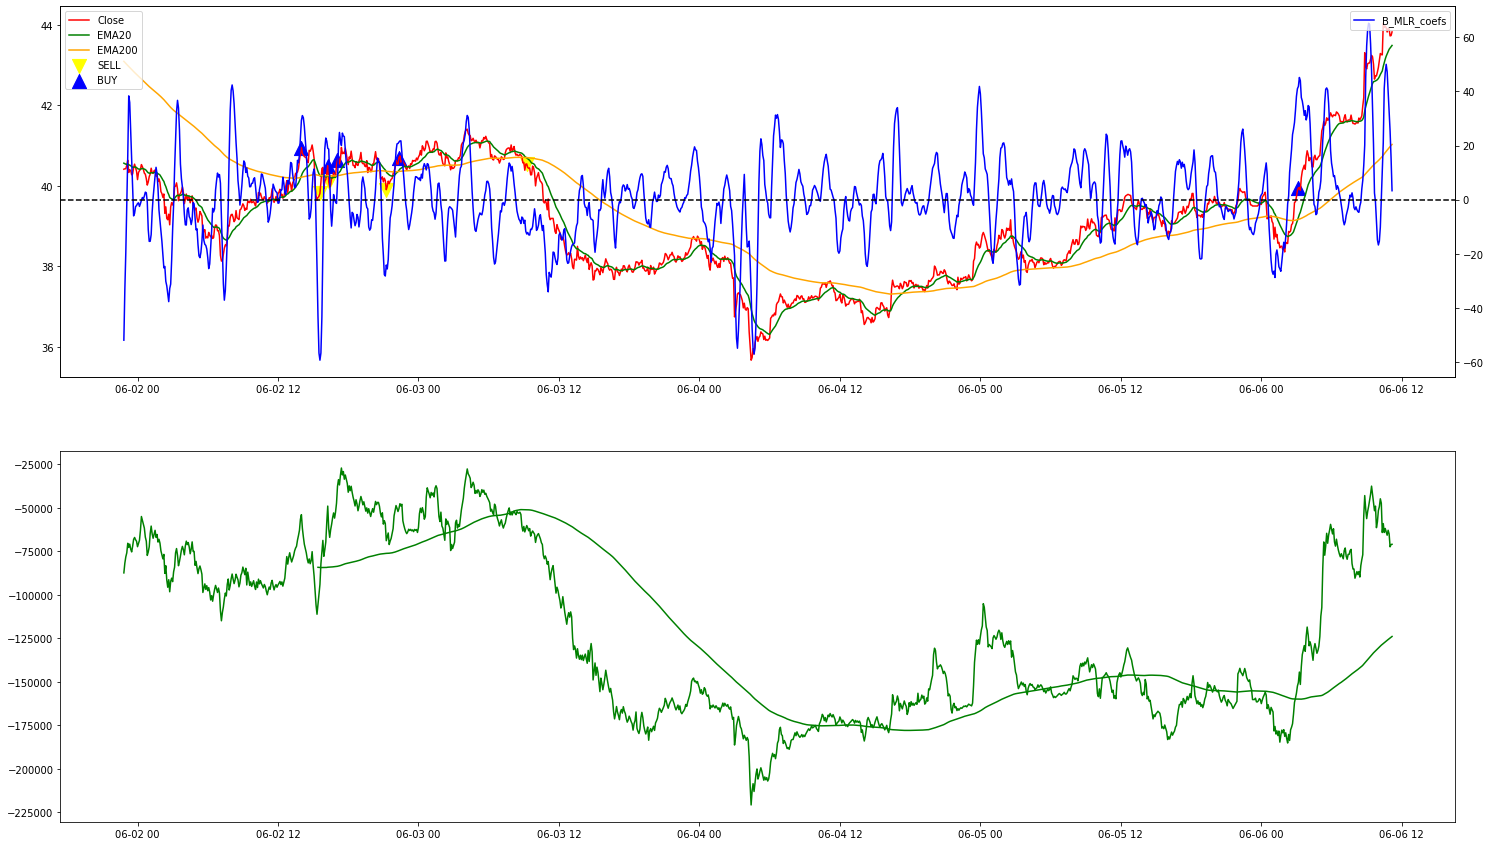

In [264]:

klines = client.get_kline('SOL-USDT','5min', startAt=round(datetime.now().timestamp())-9900000, endAt=round(datetime.now().timestamp()))
df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Volume','Amount'],dtype=float)
df = df.sort_values(by='Date')
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
print(len(df))
addIndicators(df)

#df = pd.read_csv('../backtest_tools/database/database/Binance/5m/AVAX-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
#df = df.iloc[1:]
#df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
#df = df.astype(float)
#df['Timestamp'] = df['Date'].astype(int)
#df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
#df = df.set_index('Date')
#df = addIndicators(df)
#df=df.iloc[-20000:]
#df['Close_filtered'] = lowpassfilter(df['Close'].values, 0.04)

coefs = []
window = 10
for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs.append(model.coef_[0])
    
df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs

trixLength = 5
trixSignal = 21

#df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
#df['TRIX_PCT'] = df["TRIX"].pct_change()*100
#df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
#df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
#df.dropna(inplace=True)
    
    
df['B_MLR_coefs_filtered'] =  ema_indicator(ema_indicator(ema_indicator(df['B_MLR_coefs'], window=trixLength), window=trixLength), window=trixLength)#lowpassfilter(df['B_MLR_coefs'].values, 0.1)

df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()

df['EMA200_normalized'] = (df.EMA200-df.EMA200.mean())/df.EMA200.std()
df['B_MLR_coefs_2'] = df['B_MLR_coefs']*10**5
df['New_ind'] = ((df.EMA200-df.EMA200.mean())/df.EMA200.std())-df.B_MLR_coefs*10**5

df.dropna(inplace=True)
df['BUY_SELL'] = np.nan


trades = []
df['BUY'] = np.nan
df['SELL'] = np.nan
OPENED = False
for i in range(1,len(df)):
    if OPENED == False:
        if df.EMA200[i-1]>df.EMA20[i-1] and df.EMA200[i]<df.EMA20[i] and df.B_MLR_coefs[i]>0:
            df['BUY'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'BUY'
            trades.append(df.iloc[i].values)
            OPENED = True
            LAST_BUY_PRICE = df.Close.iloc[i]
    else:
        if  df.EMA200[i-1]<df.EMA20[i-1] and df.EMA200[i]>df.EMA20[i]:
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False

    #if OPENED == False:
    #    if df['B_MLR_coefs_filtered_diff'][i]>0 and df['B_MLR_coefs'][i]<0 and (df['Stoch_RSI'][i]>0.2 and df['Close'][i]>df['EMA200'][i]):
    #        df['BUY'].iloc[i] = df.Close.iloc[i]
    #        df['BUY_SELL'].iloc[i] = 'BUY'
    #        trades.append(df.iloc[i].values)
    #        OPENED = True
    #        LAST_BUY_PRICE = df.Close.iloc[i]
    #else:
    #    if  df['B_MLR_coefs_filtered_diff'][i]<0 and df['B_MLR_coefs'][i]>0:
    #        df['SELL'].iloc[i] = df.Close.iloc[i]
    #        df['BUY_SELL'].iloc[i] = 'SELL'
    #        trades.append(df.iloc[i].values)
    #        OPENED = False
    
    
    
        #elif df['Close'][i]<=0.95*LAST_BUY_PRICE:
        #    df['SELL'].iloc[i] = df.Close.iloc[i]
        #    df['BUY_SELL'].iloc[i] = 'SELL'
        #    trades.append(df.iloc[i].values)
        #    OPENED = False
            
        
trades = pd.DataFrame(trades, columns=df.columns)
trades['Change']=trades.Close.pct_change()*100
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum())} %")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)}")
fig, ax_left = plt.subplots(2, figsize=(25,15))

ax_left[0].plot(df.Close, color='red',label='Close')
ax_left[0].plot(df.EMA20, color='green',label='EMA20')
ax_left[0].plot(df.EMA200, color='orange',label='EMA200')

#ax_left[0].plot(df.Close_filtered, color='gray',label='Close_filtered')
ax_left[0].scatter(df.index, df['SELL'], color='yellow',label='SELL',marker='v',s=200)
ax_left[0].scatter(df.index, df['BUY'], color='blue',label='BUY',marker='^',s=200)
ax_right = ax_left[0].twinx()
ax_right.plot(df.B_MLR_coefs*10**5,label='B_MLR_coefs',color='blue')
ax_right.axhline(y=0, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
ax_right.legend(loc="upper right")

ax_left[1].plot(df.OVB, color='green',label='OVB')
ax_left[1].plot(df.OVB.rolling(200).mean(), color='green',label='OVB_mean')

1500
Gain : -1 %
Winrate : 47 %
Total trades : 17


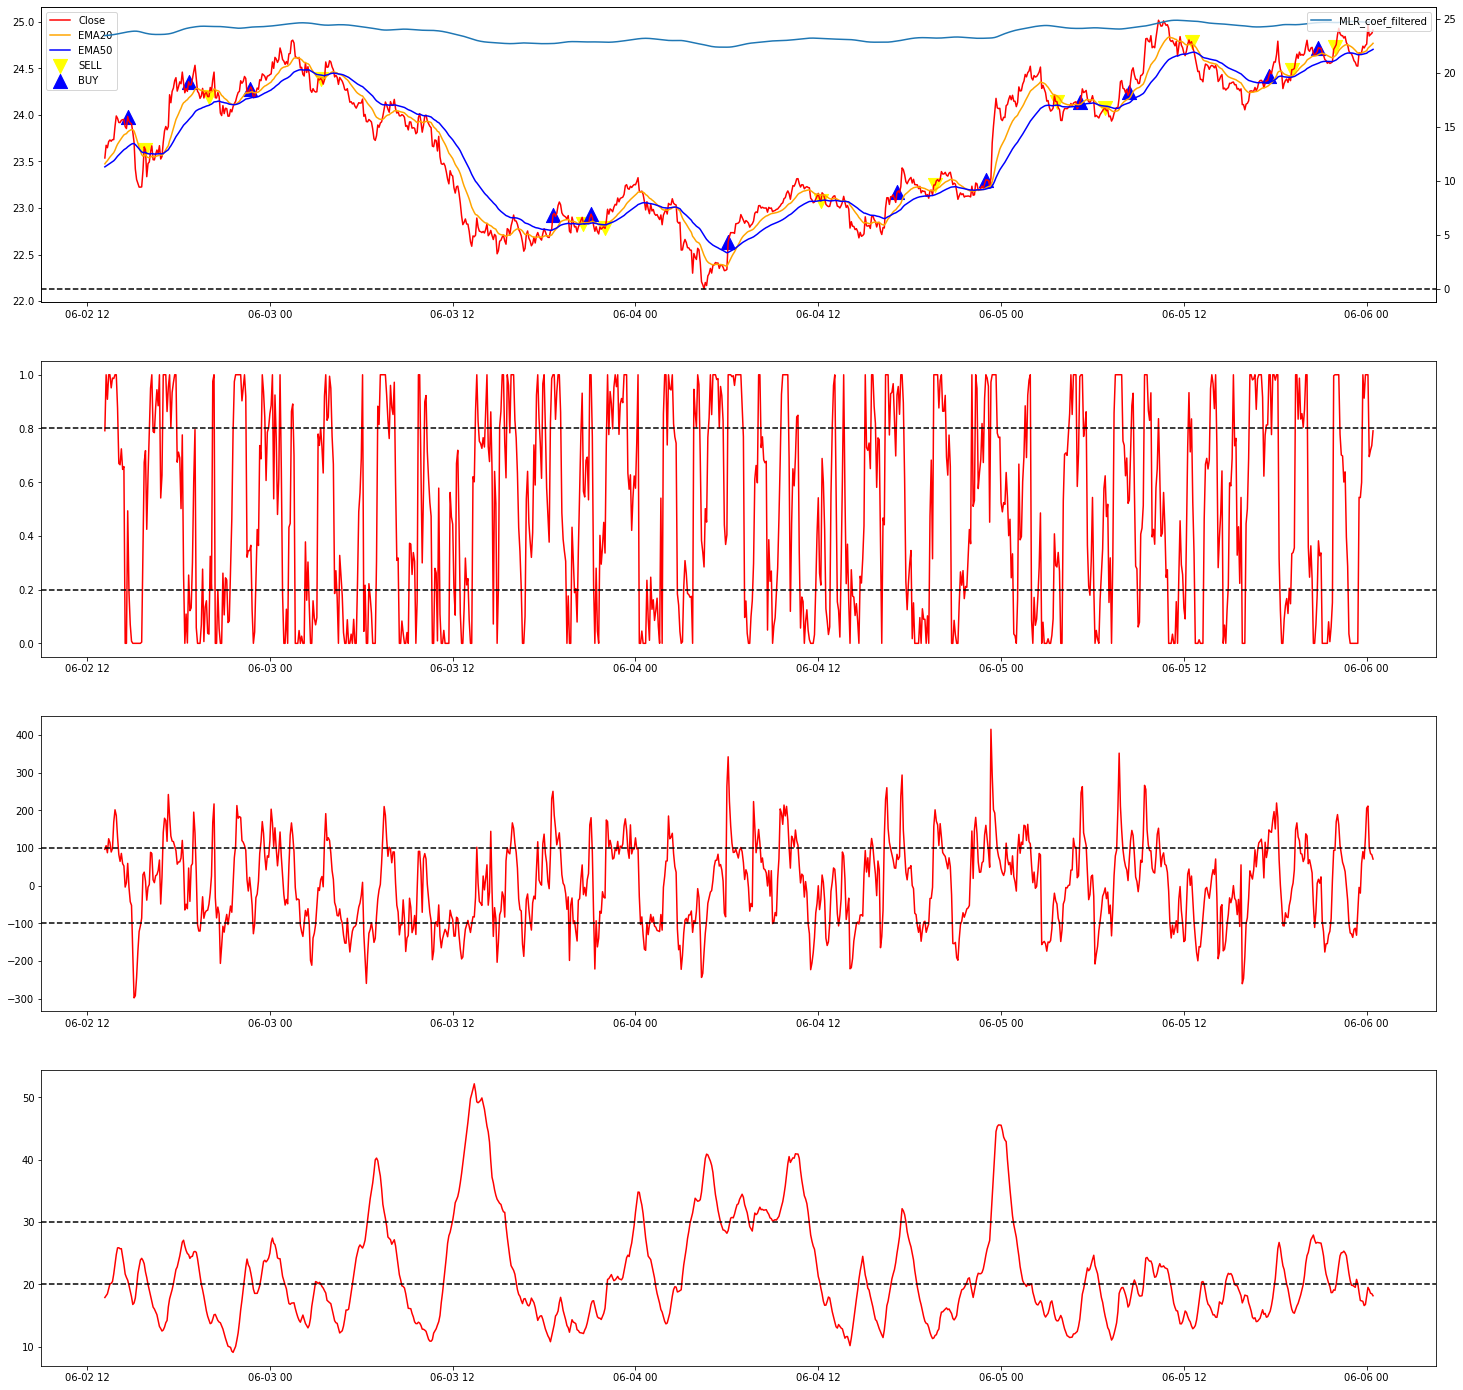

In [224]:

klines = client.get_kline('AVAX-USDT','5min', startAt=round(datetime.now().timestamp())-9900000, endAt=round(datetime.now().timestamp()))

df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Volume','Amount'],dtype=float)
df = df.sort_values(by='Date')
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
print(len(df))
df.tail()
addIndicators(df)

#df['Close_filtered'] = lowpassfilter(df['Close'].values, 0.04)


coefs = []
window = 8
for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs.append(model.coef_[0])
    
df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs

trixLength = 9
trixSignal = 21

#df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
#df['TRIX_PCT'] = df["TRIX"].pct_change()*100
#df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
#df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
#df.dropna(inplace=True)
    
    
df['B_MLR_coefs_filtered'] =  ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)#lowpassfilter(df['B_MLR_coefs'].values, 0.1)

df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff(1)
df.dropna(inplace=True)
df['BUY_SELL'] = np.nan


trades = []
df['BUY'] = np.nan
df['SELL'] = np.nan
OPENED = False
for i in range(1,len(df)):
    if OPENED == False:
        if df['B_MLR_coefs_filtered_diff'][i]>0 and df['B_MLR_coefs'][i]<0 and (df['Stoch_RSI'][i]>0.2 and df['Close'][i]>df['EMA20'][i]):
            df['BUY'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'BUY'
            trades.append(df.iloc[i].values)
            OPENED = True
            LAST_BUY_PRICE = df.Close.iloc[i]
    else:
        if  df['B_MLR_coefs_filtered_diff'][i]<0 and df['B_MLR_coefs'][i]>0:
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False
        elif df['Close'][i]<=0.95*LAST_BUY_PRICE:
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False
            
        
trades = pd.DataFrame(trades, columns=df.columns)
trades['Change']=trades.Close.pct_change()*100
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum())} %")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)}")

#start = df_tvta.timestamp.iloc[0]
#df = df[df['Timestamp']>=start]
#df_tweets= df_tweets[df_tweets['timestamp']>=start]

df = df.iloc[-1000:]
fig, ax_left = plt.subplots(4, figsize=(25,25))

ax_left[0].plot(df.Close, color='red',label='Close')
ax_left[0].plot(df.EMA20, color='orange',label='EMA20')
ax_left[0].plot(df.EMA50, color='blue',label='EMA50')
#ax_left[0].plot(df.Close_filtered, color='gray',label='Close_filtered')
ax_left[0].scatter(df.index, df['SELL'], color='yellow',label='SELL',marker='v',s=200)
ax_left[0].scatter(df.index, df['BUY'], color='blue',label='BUY',marker='^',s=200)
ax_right = ax_left[0].twinx()
ax_right.plot(df.B_MLR_coefs_filtered,label='MLR_coef_filtered')

ax_right.axhline(y=0, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
ax_right.legend(loc="upper right")

ax_left[1].plot(df.Stoch_RSI, color='red',label='Stoch_RSI')
ax_left[1].axhline(y=0.2, color='black', linestyle='--')
ax_left[1].axhline(y=0.8, color='black', linestyle='--')

ax_left[2].plot(df.CCI, color='red',label='CCI')
ax_left[2].axhline(y=100, color='black', linestyle='--')
ax_left[2].axhline(y=-100, color='black', linestyle='--')


ax_left[3].plot(df.ADX, color='red',label='ADX')
ax_left[3].axhline(y=30, color='black', linestyle='--')
ax_left[3].axhline(y=20, color='black', linestyle='--')


In [170]:
trades.Change.mean()

0.315127641043246

In [171]:
trades[trades['Change']>0].Change.mean()

0.6650002976872793

In [172]:
trades[trades['Change']<0].Change.mean()

-0.31645093188176304

In [173]:
trades[trades['Change']<0.1]['Change'].count()

225

# Live testing

In [ ]:

cryptos = ['KDA']#['ETH','BTC','SOL','KDA']
crypto_channels_slack = {'BTC':'B03EMHUP3C5/t9xTAmELtK2zfIDvAzG5Z5gz',
                'ETH':'B03GF6XNQ83/HFHrBIr8zplBHAUOzuVXb3K3',
                'KDA':'B03GHJ7JVGC/uKUFV8x2wFPemUFqwvDKQHHM',
                'SOL':'B03GCAC9ZJR/83P3iYjj0m7OuC0w6yjIECRO'}
POSITION_OPENED = {crypto:False for crypto in cryptos}

while True:
    try:
        for crypto in cryptos : 
            klines = client.get_kline(f'{crypto}-USDT','1min', startAt=round(datetime.now().timestamp())-100000, endAt=round(datetime.now().timestamp()))
            df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Transaction volume','Transaction amount'],dtype=float)
            df = df.sort_values(by='Date')
            df['Timestamp'] = df['Date'].astype(int)
            df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
            df = df.set_index('Date')
            print(len(df))
            df.tail()

            coefs_2 = []
            intercepts_2 = []

            window = 8
            for i in range(window,len(df)):
                ys = df['Close'].values[i-window:i]
                xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
                
                model = LinearRegression().fit(xs,ys)
                
                coefs_2.append(model.coef_[0])
                intercepts_2.append(model.intercept_)
                
            ratio = sum([intercepts_2[i]/[-coef for coef in coefs_2][i] for i in range(len(coefs_2))]) / len([intercepts_2[i]/[-coef for coef in coefs_2][i] for i in range(len(coefs_2))])
            df['B_MLR'] = np.nan
            df['B_MLR'].iloc[window:] = [intercepts_2[i]/ratio+coefs_2[i] for i in range(len(coefs_2))]
            df['B_MLR_coefs'] = np.nan
            df['B_MLR_coefs'].iloc[window:] = coefs_2

            df.dropna(inplace=True)
            df['B_MLR_coefs_filtered'] = savgol_filter(df['B_MLR_coefs'].values, 20, 2,mode='nearest')

            df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()
            df.dropna(inplace=True)
            df['BUY_SELL'] = np.nan
            df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" for i in range(1,len(df))]
            df.dropna(inplace=True)

            trades = df[df['BUY_SELL']!="HOLD"].iloc[1:][['Close','BUY_SELL']]
            trades['Change']=trades.Close.pct_change()*100
            trades = trades[trades['BUY_SELL']!="BUY"]
            print(df[['B_MLR_coefs_filtered_diff','BUY_SELL']].iloc[-5:])
            if 'BUY' in df[['BUY_SELL']].iloc[-5:].values and POSITION_OPENED[crypto]==False:
                results = df.iloc[-5:]
                print(f"BUY at {results[results['BUY_SELL']=='BUY'].Close.values}")
                #logging.debug(f'Time to buy {crypto} at {df["Close"].iloc[-1]} USDT !')
                #slack_api.sendMessage(f'Time to buy {crypto} at {df["Close"].iloc[-1]} USDT !',crypto_channels_slack[crypto])
                POSITION_OPENED[crypto] = True
            elif 'SELL' in df[['BUY_SELL']].iloc[-5:].values and POSITION_OPENED[crypto]==True:
                results = df.iloc[-5:]
                print(f"SELL at {results[results['BUY_SELL']=='SELL'].Close.values}")
                #logging.debug(f'Time to sell {crypto} at {df["Close"].iloc[-1]} USDT !')
                #slack_api.sendMessage(f'Time to sell {crypto} at {df["Close"].iloc[-1]} USDT !',crypto_channels_slack[crypto])
                POSITION_OPENED[crypto] = False        
        time.sleep(60)
    except:
        print(traceback.format_exc())
   